In [125]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

In [99]:
def read_data(filename, data_dir='data'):
    df = pd.read_csv(os.path.join(data_dir, filename), index_col=0)
    df.fillna('?', inplace=True)
    return df

df_train = read_data('diab_train_filtered.csv')
df_val = read_data('diab_validation_filtered.csv')
df_test = read_data('diab_test_filtered.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 9011 to 1625
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      6000 non-null   object
 1   gender                    6000 non-null   object
 2   age                       6000 non-null   object
 3   admission_type_id         6000 non-null   object
 4   discharge_disposition_id  6000 non-null   object
 5   admission_source_id       6000 non-null   object
 6   time_in_hospital          6000 non-null   int64 
 7   num_lab_procedures        6000 non-null   int64 
 8   num_procedures            6000 non-null   int64 
 9   num_medications           6000 non-null   int64 
 10  number_outpatient         6000 non-null   int64 
 11  number_emergency          6000 non-null   int64 
 12  number_inpatient          6000 non-null   int64 
 13  diag_1                    6000 non-null   int64 
 14  number_diagnoses     

### Prepare data
Replace categorical variables by one-hot encodings, ignore text for now

In [101]:
def prepare_data(df, mlb, scaler, categorical_vars, numerical_vars):
    categoricals = pd.get_dummies(df[categorical_vars])
    
    y = df.readmitted
    x = df.drop(columns=['readmitted', 'diag_1_desc'] + categorical_vars)
    x[numerical_vars] = scaler.transform(x[numerical_vars])
    x = x.join(categoricals)
    return x, y

In [102]:
categorical_vars = ['race', 'age', 'gender', 'diag_1', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', \
                    'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed']
numerical_vars = df_train.columns[6:13].tolist() + [df_train.columns[14]]

scaler = StandardScaler()
scaler.fit(df_train[numerical_vars])

X_train, Y_train = prepare_data(df_train, mlb, scaler, categorical_vars, numerical_vars)
X_val, Y_val = prepare_data(df_val, mlb, scaler, categorical_vars, numerical_vars)
X_test, Y_test = prepare_data(df_test, mlb, scaler, categorical_vars, numerical_vars)

In [103]:
X_train.shape, X_test.shape, X_val.shape

((6000, 41), (2000, 41), (2000, 41))

## Feature Importance
We train a Random Forest Classifier and extract the feature importances. This is plotted in the graph below.

We find that the number of lab procedures, number of medications, time in hospital, number of diagnostics and number of procedures seem to be the most relevant features.

By training models that start by using only the most important feature, and successively add the next most important one, and plotting their validation and train accuracy, we see that using these less important features leads the model to aggressively overfitting.

0.641


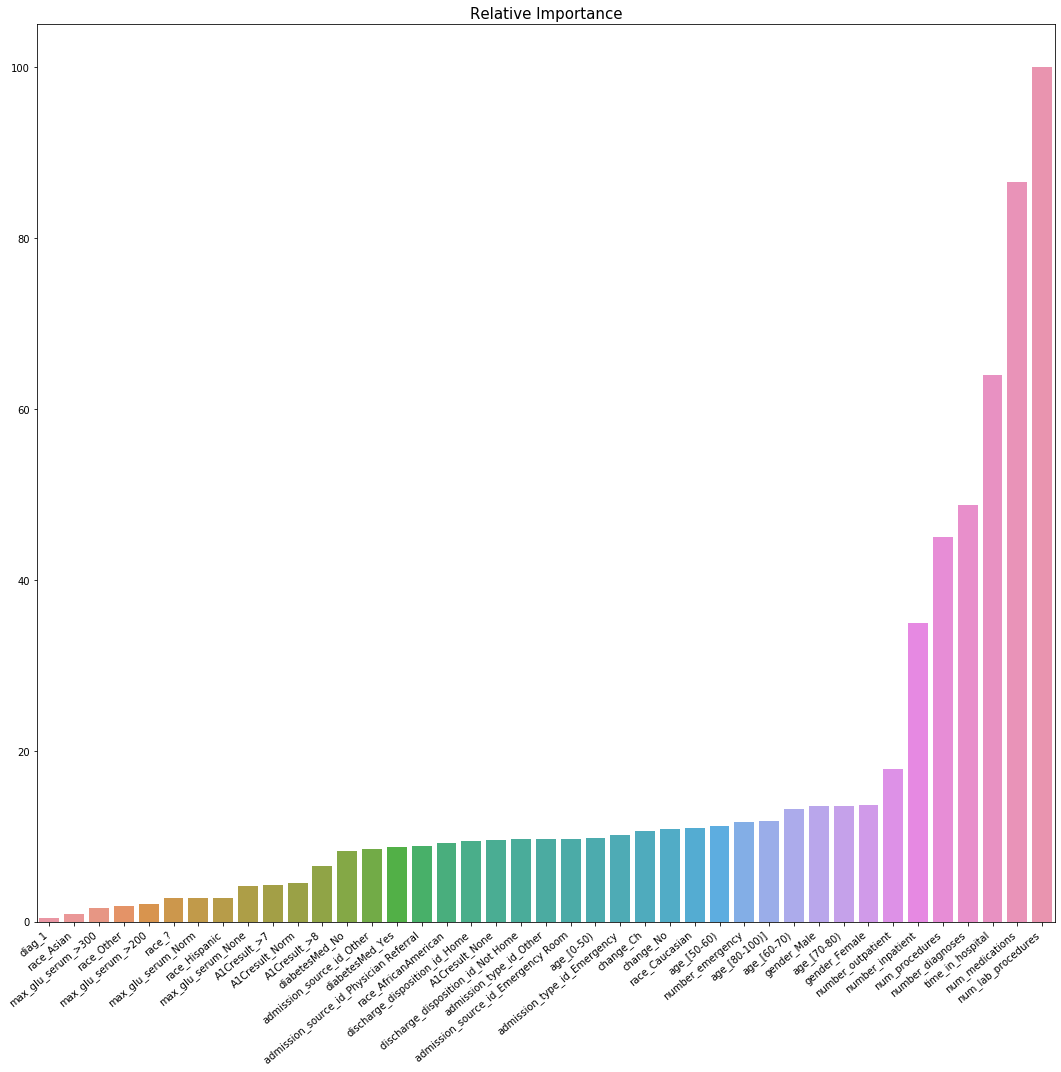

In [126]:
clf = RandomForestClassifier()
clf.fit(X_train, Y_train)
print(clf.score(X_val, Y_val))
importances = forest.feature_importances_

relative = 100 * (importances / importances.max())
indices = np.argsort(feature_importance)
features = X_train.columns.values.tolist()
feature_names_sort = [feature_names[i] for i in indices]

plt.figure(figsize=(15, 15))
plt.title('Relative Importance', fontsize=15)
ax = sns.barplot(x=feature_names_sort, y=feature_importance[sorted_idx])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

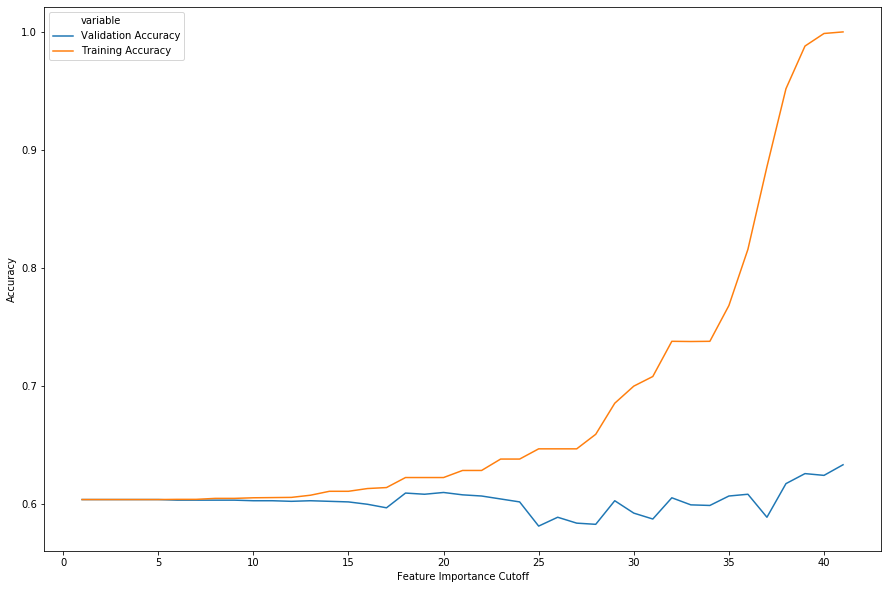

In [179]:
train_acc = []
val_acc = []
cutoff = []
for i in range(1, X_train.columns.shape[0] + 1):
    clf = RandomForestClassifier()
    filtered = X_train.columns[indices[:i]].tolist()
    clf.fit(X_train[filtered], Y_train)
    train_acc.append(clf.score(X_train[filtered], Y_train))
    val_acc.append(clf.score(X_val[filtered], Y_val))
    cutoff.append(i)

data = pd.DataFrame({
    'Feature Importance Cutoff': cutoff,
    'Validation Accuracy': val_acc,
    'Training Accuracy' : train_acc
})
plt.figure(figsize=(15, 10))
sns.lineplot(x='Feature Importance Cutoff', y='Accuracy', hue='variable', 
             data=pd.melt(data, ['Feature Importance Cutoff'], value_name='Accuracy'))